In [1]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_rel
import warnings

def day_to_phase(day: int) -> str:
    if day < 0:  return "empty"
    if day < 9:  return "social"
    return "extinction"

def day_to_mode(day: int) -> str:
    if day < 0:  return "Empty"
    if day < 9:  return "Social"
    return "Extinction"

def sem(x):
    x = np.asarray(x)
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0.0

def add_sig_star(ax, x1, x2, y, p_val, fontsize=14):
    """Draw significance stars centered between x1 and x2 at height y."""
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom',
            fontsize=fontsize, fontweight='bold')

warnings.filterwarnings("ignore")

No Partner $\longrightarrow$ Partner 1: n=10, t=-9.513, p=5.412e-06
Partner 1 $\longrightarrow$ Partner 2: n=10, t=1.057, p=3.180e-01
Partner 2 $\longrightarrow$ Partner 3: n=9, t=-3.447, p=8.730e-03
Partner 3 $\longrightarrow$ No Partner: n=10, t=1.044, p=3.235e-01


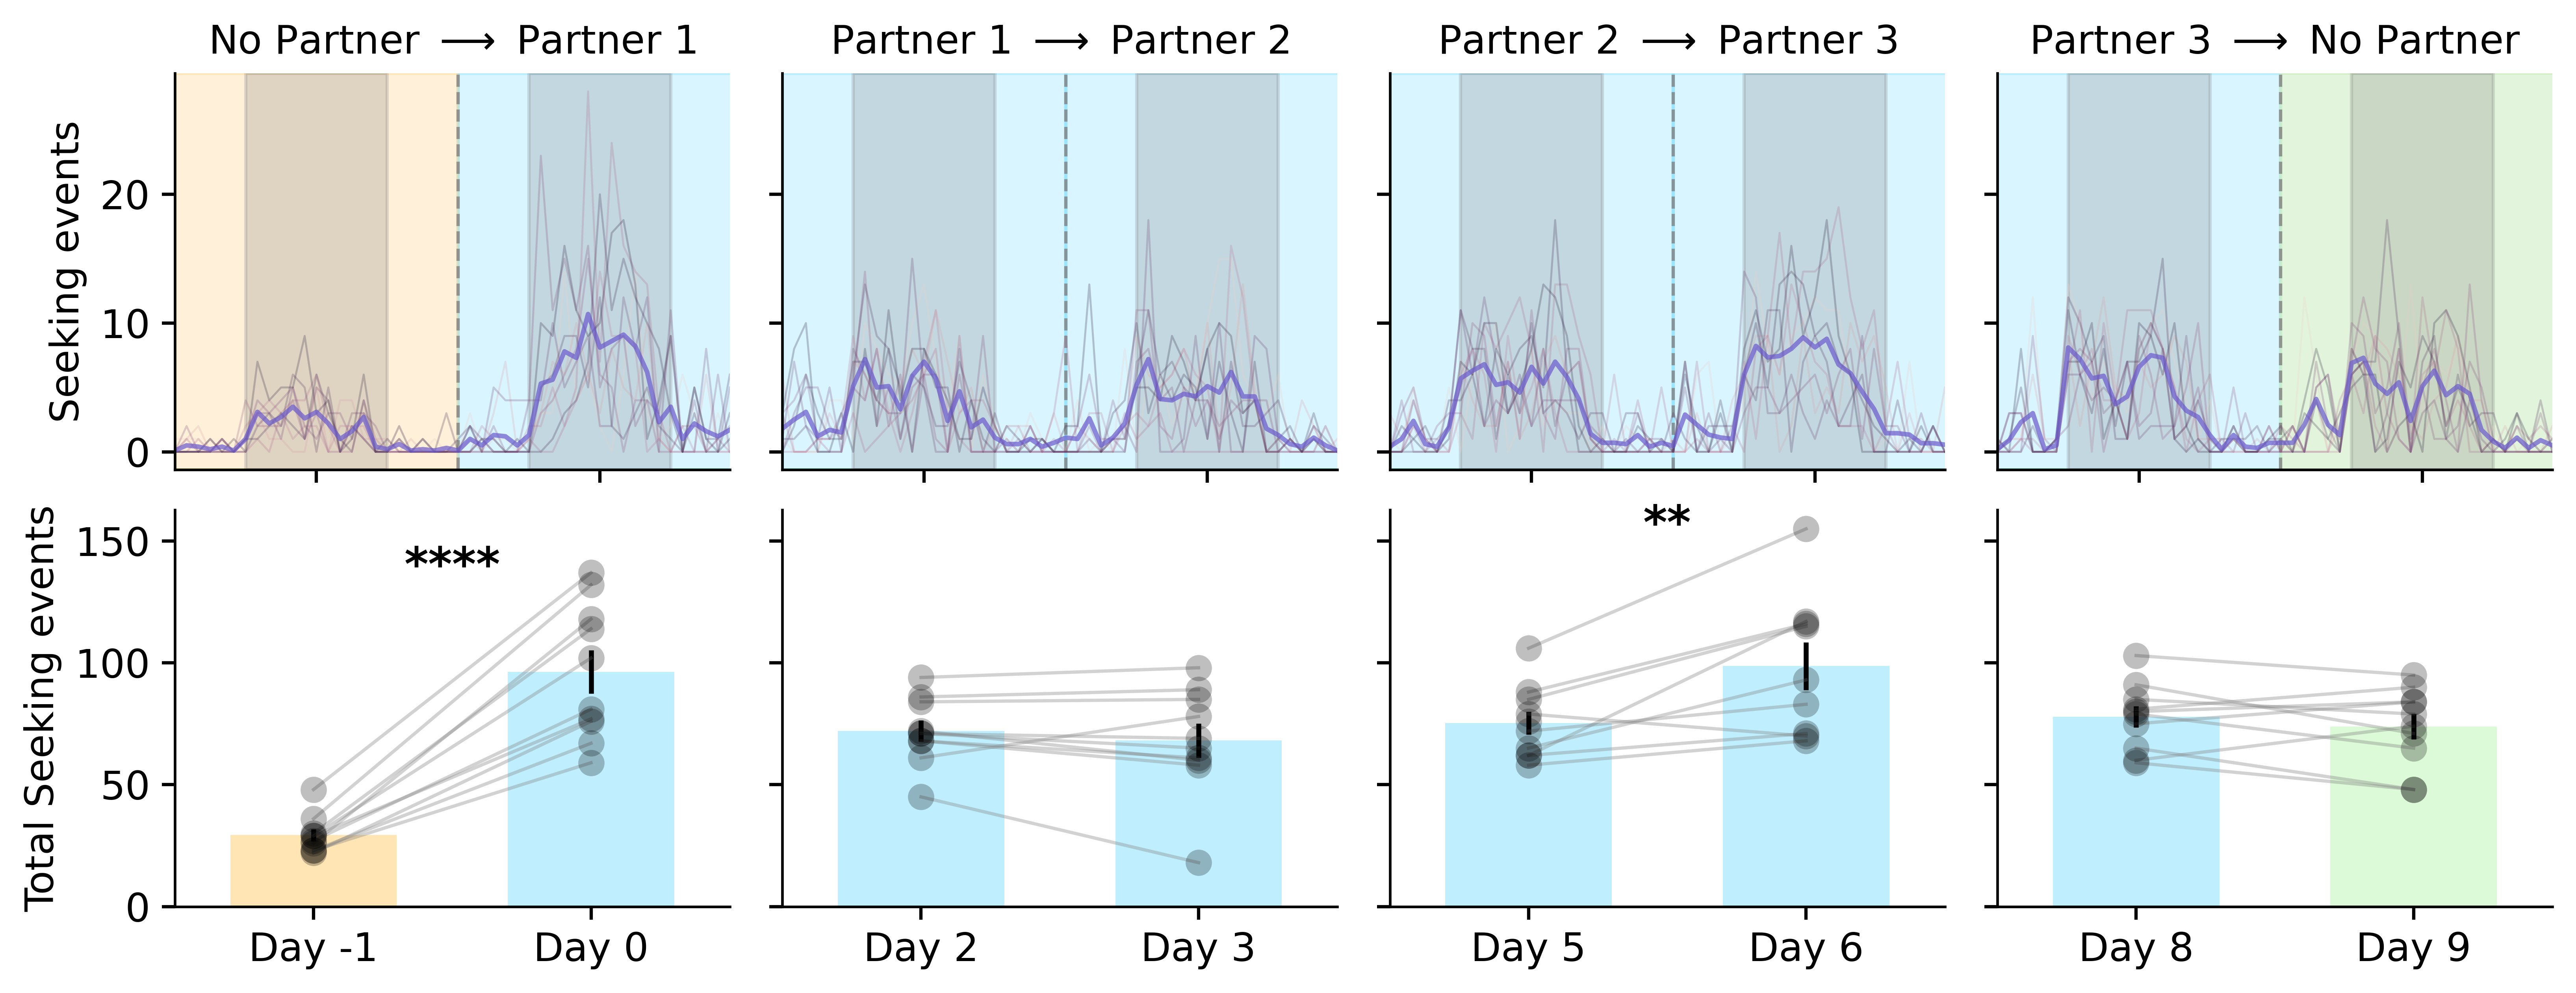

In [2]:
# @title Figure S3
# Load and preprocess data
poke_counts = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS3top.csv")
day_sums = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2026/main/Data/data_FigureS3btm.csv")

windows = [(-1, 0), (2, 3), (5, 6), (8, 9)]
titles = [
    r"No Partner $\longrightarrow$ Partner 1",
    r"Partner 1 $\longrightarrow$ Partner 2",
    r"Partner 2 $\longrightarrow$ Partner 3",
    r"Partner 3 $\longrightarrow$ No Partner",
]

# --- colors for backgrounds and bars ---
MODE_COLORS = {"Empty": "#FFA500", "Social": "#00BFFF", "Extinction": "#C7ECBA"}
MODE_ALPHA  = {"Empty": 0.15, "Social": 0.15, "Extinction": 0.5}
PHASE_COLORS = {"empty": "#FFE5B4", "social": "#BFEFFF", "extinction": "#DCFAD7"}

# ======================================================
# CREATE 2×4 FIGURE
# ======================================================
fig, axs = plt.subplots(2, 4, figsize=(11, 4.3), dpi=600, sharey='row')

# ======================================================
# TOP ROW: LINE PLOTS (poke_counts)
# ======================================================
def draw_line_panel(ax, start_day, end_day, poke_counts):
    avg_counts = (
        poke_counts.groupby(["hoursfloor"])
        .agg(mean_count=("count", "mean"))
        .reset_index()
    )

    h0, h1 = start_day * 24, (end_day + 1) * 24

    # color bands by mode
    for d in range(start_day, end_day + 1):
        mode = day_to_mode(d)
        ax.axvspan(d * 24, (d + 1) * 24,
                   color=MODE_COLORS[mode],
                   alpha=MODE_ALPHA[mode], zorder=-2)

    # night shading
    for d in range(start_day, end_day + 1):
        night_start, night_end = d * 24 + 6, d * 24 + 18
        ax.axvspan(night_start, night_end, color="grey", alpha=0.25, zorder=-1)

    # dashed day separators
    for x in [0, 72, 144, 216]:
        if h0 <= x < h1:
            ax.axvline(x, linestyle="--", color="grey", linewidth=1.0, alpha=0.8, zorder=2)

    # individual traces
    tmp = poke_counts[(poke_counts["hoursfloor"] >= h0) & (poke_counts["hoursfloor"] < h1)]
    tmp = tmp.groupby(["device_number", "hoursfloor"])["count"].mean().reset_index()
    sns.lineplot(data=tmp, x="hoursfloor", y="count", hue="device_number",
                 estimator=None, lw=0.6, alpha=0.25, legend=False, ax=ax)

    # mean trace
    sub = avg_counts[(avg_counts["hoursfloor"] >= h0) & (avg_counts["hoursfloor"] < h1)]
    sns.lineplot(data=sub, x="hoursfloor", y="mean_count", ax=ax,
                 lw=1.4, color="slateblue", alpha=0.7)

    # format
    ax.set_xlabel("")
    ax.set_ylabel("Seeking events", fontsize=12)
    day_mids = [d * 24 + 12 for d in range(start_day, end_day + 1)]
    ax.set_xticks(day_mids)
    ax.set_xticklabels([str(d) for d in range(start_day, end_day + 1)], fontsize=11)
    ax.set_xlim(h0, h1 - 1)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.tick_params(axis="both", which="major", left=True, bottom=True, length=4, width=1, direction="out", labelsize=12)
    sns.despine(ax=ax)
    ax.legend([], frameon=False)

# plot top row
for ax, (d0, d1), title in zip(axs[0], windows, titles):
    draw_line_panel(ax, d0, d1, poke_counts)
    ax.set_title(title, fontsize=12)

# ======================================================
# BOTTOM ROW: BAR PLOTS (day_sums)
# ======================================================
for ax, ((d0, d1), title) in zip(axs[1], zip(windows, titles)):
    dfw = day_sums[day_sums['window'] == title].copy()

    # bar colors
    bar_colors = [PHASE_COLORS[day_to_phase(d0)], PHASE_COLORS[day_to_phase(d1)]]

    # means/SEMs
    left_vals  = dfw.loc[dfw['day'] == d0, 'sum_events']
    right_vals = dfw.loc[dfw['day'] == d1, 'sum_events']
    means = [left_vals.mean(), right_vals.mean()]
    sems  = [sem(left_vals.values), sem(right_vals.values)]

    # bars at x=0,1
    ax.bar([0, 1], means, yerr=sems, width=0.6,
           color=bar_colors, capsize=0, zorder=1)

    # paired lines
    wide = dfw.pivot_table(index='device_number', columns='day', values='sum_events', aggfunc='mean')
    
    if d0 in wide.columns and d1 in wide.columns:
        for dev, row in wide[[d0, d1]].dropna().iterrows():
            ax.plot([0, 1], [row[d0], row[d1]], color="0.5", alpha=0.35, linewidth=1.0, zorder=2)

    # non-jittered dots
    sns.stripplot(
        data=dfw, x="day_label", y="sum_events",
        order=[f"Day {d0}", f"Day {d1}"],
        dodge=True, jitter=False,
        color='black', alpha=0.25, size=8,
        ax=ax, zorder=3
    )

    # paired t-test + stars
    pairs = wide[[d0, d1]].dropna()
    if len(pairs) >= 2:
        t_stat, p_val = ttest_rel(pairs[d0], pairs[d1])
        print(f"{title}: n={len(pairs)}, t={t_stat:.3f}, p={p_val:.3e}")
        y_max = max(np.nanmax(pairs.values), max(means))
        pad = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        y_star = y_max - pad
        add_sig_star(ax, 0, 1, y_star, p_val)

    # cosmetics
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"Day {d0}", f"Day {d1}"], fontsize=11)
    ax.set_xlabel("")
    ax.set_xlim(-0.5, 1.5)
    ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    ax.tick_params(axis="both", which="major", left=True, bottom=True, length=4, width=1, direction="out", labelsize=12)
    sns.despine(ax=ax)

axs[1, 0].set_ylabel("Total Seeking events", fontsize=12)

fig.tight_layout(h_pad=0.5, w_pad=1.2)

plt.show()